# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [74]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
% matplotlib inline
import re
from pandas.io.json import json_normalize
import seaborn as sns
from timeit import default_timer as timer
import datetime

from funk_svd import SVD

ModuleNotFoundError: No module named 'funk_svd'

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data Exploration and Cleaning

Let's take a look through the dataframes we are working with for the project and clean the data as we go.

In [3]:
# porfolio contains information about the 10 offers send to users.
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


We should create a unique column for each channel to be able to use that information later on.

In [4]:
# create a new column for each channel
portfolio['channel_web'],  portfolio['channel_email'], portfolio['channel_mobile'], portfolio['channel_social']= 0, 0, 0, 0



In [5]:
# Label the data by iterating over the list data for each offer
for i, row in portfolio.iterrows():
    if 'web' in portfolio.channels[i]:
        portfolio['channel_web'][i] = 1
    if 'email' in portfolio.channels[i]:
        portfolio['channel_email'][i] = 1
    if 'mobile' in portfolio.channels[i]:
        portfolio['channel_mobile'][i] = 1
    if 'social' in portfolio.channels[i]:
        portfolio['channel_social'][i] = 1
    


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is tryin

In [6]:
# we can now drop the channels column
portfolio.drop('channels', axis=1, inplace=True)

In [7]:
# add a new column that tracks the duration in hours as it is currently in days
portfolio['duration_hours'] = portfolio['duration'] * 24

In [8]:
# let's add a unique id for each offer to help us track them across dataframes.
# I grabbed this code from the previous udacity IBM recommendation project
def offer_mapper():
    coded_dict = dict()
    cter = 1
    offer_id_encoded = []
    
    for val in portfolio['id']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        offer_id_encoded.append(coded_dict[val])
    return offer_id_encoded

offer_id_encoded = offer_mapper()
portfolio['offer_id'] = offer_id_encoded

In [9]:
# Let's check the changes to the dataframe
portfolio

,difficulty,duration,id,offer_type,reward,channel_web,channel_email,channel_mobile,channel_social,duration_hours,offer_id
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1,168,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1,120,2
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,1,0,96,3
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,1,0,168,4
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,1,0,0,240,5
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1,168,6
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1,240,7
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,1,1,1,72,8
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1,120,9
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,1,0,168,10


In [10]:
# Let's take a look at the profile dataframe
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [11]:
# Let's take a look at the missing data from the profile dataframe
profile.gender.isna().value_counts(), profile.income.isna().value_counts()

(False    14825
 True      2175
 Name: gender, dtype: int64, False    14825
 True      2175
 Name: income, dtype: int64)

2175 users don't have age, gender or income data.

In [12]:
# Lets look at the profile stats
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [13]:
# Create user_ids for each user in the profile dataframe
def id_mapper():
    coded_dict = dict()
    cter = 1
    id_encoded = []
    
    for val in profile['id']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        id_encoded.append(coded_dict[val])
    return id_encoded

id_encoded = id_mapper()
profile['user_id'] = id_encoded

# show header
profile.head()

,age,became_member_on,gender,id,income,user_id
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,1
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,3
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,4
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN,5


In [14]:
# Let's look at the transcript dataframe
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [15]:
# How many of each type of event is in the transcript dataframe
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [16]:
# Create new dataframe that joins the transcript to the profile, 
# so we can get demographic information about the events
df = transcript.join(profile.set_index('id'), on='person')
df.shape

(306534, 9)

In [17]:
df.head()

,event,person,time,value,age,became_member_on,gender,income,user_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},75,20170509,F,100000.0,4
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},118,20170804,None,NaN,5
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},68,20180426,M,70000.0,6
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},118,20170925,None,NaN,7
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},118,20171002,None,NaN,8


We need to extract the information from the dict values in the value column. 

In [18]:
# use json_normalize to get event data and create a new data frame 
# which contains the offer id which we need to use to join the portfolio dataframe
offers = json_normalize(df['value'])

In [19]:
offers.head()

,amount,offer id,offer_id,reward
0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


In [20]:
# join the offers dataframe to the main event + demographics df dataframe
df = df.join(offers, how='outer')

In [21]:
# Create a column that combines the offer ids 
# different offer event had different offer id labels ('offer id' and 'offer_id').
df['offer_id'] = df.offer_id.combine_first(df['offer id'])

In [22]:
# drop the offer id column as all the offer ids are now in the offer_id columns
df.drop(['offer id', 'value', 'person'], axis=1, inplace=True)

In [23]:
df.head()

,event,time,age,became_member_on,gender,income,user_id,amount,offer_id,reward
0,offer received,0,75,20170509,F,100000.0,4,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,0,118,20170804,None,NaN,5,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,offer received,0,68,20180426,M,70000.0,6,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,offer received,0,118,20170925,None,NaN,7,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,offer received,0,118,20171002,None,NaN,8,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [24]:
#Let's take a quick look at the amounts spent and rewards earned across this dataset
user_rewards_earned = df.groupby('user_id')['reward'].sum().sort_values(ascending=False)
user_amount_spent = df.groupby('user_id')['amount'].sum().sort_values(ascending=False)

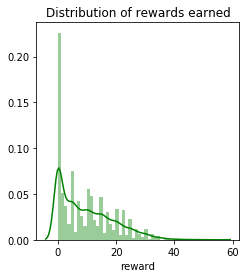

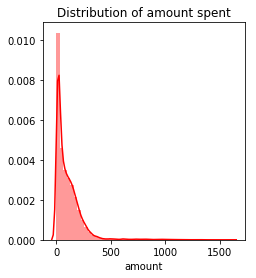

In [25]:
# plot distribution of amount spent or reward earned across the users in the dataframe
plt.figure(figsize=(8,4))
plt.subplot(121)
sns.distplot(user_rewards_earned, color='green');
plt.title('Distribution of rewards earned')
plt.figure(figsize=(8,4))
plt.subplot(122)
sns.distplot(user_amount_spent,  color='red');
plt.title('Distribution of amount spent')
plt.show()

Both distributions of the amount spent and rewards earned are right skewed.

We need to create categorical columns for the age ranges and income ranges to be able to chart the differences of order completions across groups.

In [26]:
age_range = []
for a in profile.age:
    if a == 118:
        age_range.append(np.nan)
    elif a >= 18 and a <=24:
        age_range.append('18-24')
    elif a >= 25 and a <=34:
        age_range.append('25-34')
    elif a >= 35 and a <=44:
        age_range.append('35-44')
    elif a >= 45 and a <=54:
        age_range.append('45-54')
    elif a >= 55 and a <=64:
        age_range.append('55-64')
    elif a >= 65 and a <=74:
        age_range.append('65-74')
    elif a >= 75 and a < 117:
        age_range.append('75+')

age_range_df = []
for a in df.age:
    if a == 118:
        age_range_df.append(np.nan)
    elif a >= 18 and a <=24:
        age_range_df.append('18-24')
    elif a >= 25 and a <=34:
        age_range_df.append('25-34')
    elif a >= 35 and a <=44:
        age_range_df.append('35-44')
    elif a >= 45 and a <=54:
        age_range_df.append('45-54')
    elif a >= 55 and a <=64:
        age_range_df.append('55-64')
    elif a >= 65 and a <=74:
        age_range_df.append('65-74')
    elif a >= 75 and a < 117:
        age_range_df.append('75+')
len(age_range_df), len(df.age)
        
len(age_range), len(profile.age)

(17000, 17000)

In [27]:
p_income_range = []
for i in profile.income:
    if i >=30000 and i <49000:
        p_income_range.append('30k-49k')
    elif i >=49000 and i <64000:
        p_income_range.append('49k-64k')
    elif i >=64000 and i <80000:
        p_income_range.append('64k-80k')
    elif i >=80000 and i <120000:
        p_income_range.append('80k-120k')
    else:
        p_income_range.append(np.nan)
print(len(p_income_range), len(profile.income))
        
df_income_range = []
for i in df.income:
    if i >=30000 and i <49000:
        df_income_range.append('30k-49k')
    elif i >=49000 and i <64000:
        df_income_range.append('49k-64k')
    elif i >=64000 and i <80000:
        df_income_range.append('64k-80k')
    elif i >=80000 and i <120000:
        df_income_range.append('80k-120k')
    else:
        df_income_range.append(np.nan)

17000 17000


In [28]:
# create columns in each dataframe for the age range and income range
profile['age_range'] = age_range
df['age_range'] = age_range_df
profile['income_range'] = p_income_range
df['income_range'] = df_income_range

In [29]:
# Replace age 118 with nan value
profile.age.replace(118, np.nan, inplace=True)
df.age.replace(118, np.nan, inplace=True)

In [30]:
# input nan in gender columns
df.gender.fillna(value=pd.np.nan, inplace=True)
profile.gender.fillna(value=pd.np.nan, inplace=True)

In [31]:
# combine portfolio with the master dataframe
df = df.merge(portfolio, how='left', left_on='offer_id', right_on='id')

In [32]:
# We can drop value, offer id and person columns from the master dataframe df
df.head()


,event,time,age,became_member_on,gender,income,user_id,amount,offer_id_x,reward_x,...,duration,id,offer_type,reward_y,channel_web,channel_email,channel_mobile,channel_social,duration_hours,offer_id_y
0,offer received,0,75.0,20170509,F,100000.0,4,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,...,7.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5.0,1.0,1.0,1.0,0.0,168.0,4.0
1,offer received,0,NaN,20170804,NaN,NaN,5,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,...,10.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5.0,1.0,1.0,0.0,0.0,240.0,5.0
2,offer received,0,68.0,20180426,M,70000.0,6,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,...,7.0,2906b810c7d4411798c6938adc9daaa5,discount,2.0,1.0,1.0,1.0,0.0,168.0,10.0
3,offer received,0,NaN,20170925,NaN,NaN,7,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,...,10.0,fafdcd668e3743c1bb461111dcafc2a4,discount,2.0,1.0,1.0,1.0,1.0,240.0,7.0
4,offer received,0,NaN,20171002,NaN,NaN,8,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,...,5.0,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10.0,1.0,1.0,1.0,1.0,120.0,2.0


In [33]:
# let's take a quick look at the number of offers completed across the two offer types
offer_completed = df.query('event == "offer completed"')

In [34]:
# Take a rough look at the number of offers completed 
# from the two offers types we can get this information for at the moment (bogo and discount)
offer_completed.offer_type.value_counts()

discount    17910
bogo        15669
Name: offer_type, dtype: int64

In [35]:
# Calculate the total amount spent and the total rewards earned
reward_sum = offer_completed.reward_x.sum()
transaction = df.query('event == "transaction"')
transaction_sum = round(transaction.amount.sum(), 2)

print("The total amount spent is ${}. \nThe total rewards earned is ${}. \nThe total amount minus rewards is ${}.".format(transaction_sum, reward_sum, transaction_sum-reward_sum))


The total amount spent is $1775451.97. 
The total rewards earned is $164676.0. 
The total amount minus rewards is $1610775.97.


In [36]:
# Let's clean the data to remove any user with NaN values for age, gender or income.
df_clean = df[~df.age.isna()]

In [37]:
df[~df.age.isna()].gender.isna().value_counts()

False    272762
Name: gender, dtype: int64

In [38]:
df.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [39]:
df_clean.gender.value_counts()


M    155690
F    113101
O      3971
Name: gender, dtype: int64

In [40]:
amount_spent_age = pd.DataFrame(df_clean.groupby(['age_range'])['amount'].sum())
amount_spent_income = pd.DataFrame(df_clean.groupby('income_range')['amount'].sum())

reward_earned_age = pd.DataFrame(df_clean.groupby(['age_range'])['reward_x'].sum())
reward_earned_income = pd.DataFrame(df_clean.groupby('income_range')['reward_x'].sum())
reward_earned_income.reward_x/amount_spent_income.amount,reward_earned_age.reward_x/amount_spent_age.amount 

(income_range
 30k-49k     0.109003
 49k-64k     0.104614
 64k-80k     0.091421
 80k-120k    0.080501
 dtype: float64, age_range
 18-24    0.092443
 25-34    0.098441
 35-44    0.092451
 45-54    0.096112
 55-64    0.091948
 65-74    0.089017
 75+      0.090120
 dtype: float64)

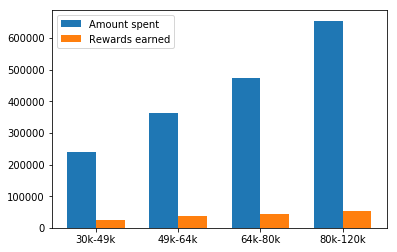

In [41]:
ind = np.arange(len(amount_spent_income.amount))  # the x locations for the groups
width = 0.35
fig, ax = plt.subplots();
rects1 = ax.bar(ind - width/2, amount_spent_income.amount, width,
                label='Amount spent')
rects2 = ax.bar(ind + width/2, reward_earned_income.reward_x, width,
                label='Rewards earned')

ax.set_ylabel('')
ax.set_title('')
ax.set_xticks(ind)
ax.set_xticklabels(amount_spent_income.index)
ax.legend();

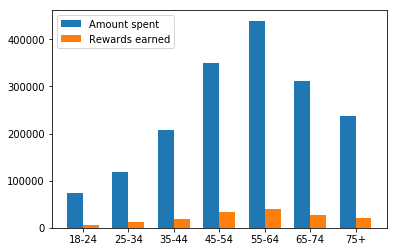

In [42]:
ind = np.arange(len(amount_spent_age.amount))  # the x locations for the groups
width = 0.35
fig, ax = plt.subplots();
rects1 = ax.bar(ind - width/2, amount_spent_age.amount, width,
                label='Amount spent')
rects2 = ax.bar(ind + width/2, reward_earned_age.reward_x, width,
                label='Rewards earned')

ax.set_ylabel('')
ax.set_title('')
ax.set_xticks(ind)
ax.set_xticklabels(amount_spent_age.index)
ax.legend();

### Let's take a quick look at the distribution of the number of offers received by users.

In [43]:
# look at the value_counts per user
num_offers_received = df.groupby(['user_id'])['offer_id_y'].count().sort_values(ascending=False)
num_offers_received.value_counts()

10    2074
8     2069
9     2041
11    1843
12    1664
7     1430
6     1215
13    1181
14    1058
5      657
15     615
4      340
16     311
17     219
3      151
2       63
18      59
0        6
1        4
Name: offer_id_y, dtype: int64

Text(0,0.5,'Number of users')

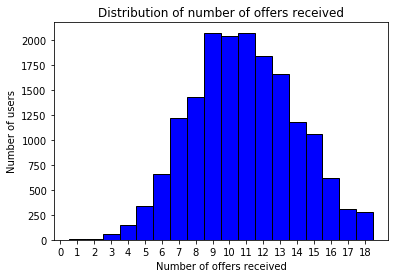

In [44]:
# plot distribution of number of offers received by users
bins=19
plt.hist(num_offers_received, color='blue', bins=range(19), align='right', edgecolor="k");
plt.xticks(np.arange(19))
plt.title('Distribution of number of offers received')
plt.xlabel('Number of offers received');
plt.ylabel('Number of users')

###### It looks like a pretty normal distribution with the majority of users receiving 6 to 13 offers.

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 23 columns):
event               306534 non-null object
time                306534 non-null int64
age                 272762 non-null float64
became_member_on    306534 non-null int64
gender              272762 non-null object
income              272762 non-null float64
user_id             306534 non-null int64
amount              138953 non-null float64
offer_id_x          167581 non-null object
reward_x            33579 non-null float64
age_range           272762 non-null object
income_range        272529 non-null object
difficulty          167581 non-null float64
duration            167581 non-null float64
id                  167581 non-null object
offer_type          167581 non-null object
reward_y            167581 non-null float64
channel_web         167581 non-null float64
channel_email       167581 non-null float64
channel_mobile      167581 non-null float64
channel_social      167

HAve to turn became_member_on to a datetime object

## Tracking offer completions

I need to create a function that tracks when an offer is received and if it is viewed before the offer is completed.

I will need to also track offer completions for informational offers by tracking if there are transactions after the offer is viewed and before the offer end time.

I need to add a check to see when offer received and determine from that time whether an offer was completed (not by the viewed time for both functions). 

I need to make sure the offer was viewed prior to the transaction in order to count the transactions. So time from received and after a viewed time.

In [46]:
def info_offer_completions(user_id, df=df_clean, offer_id=3):
    '''
    inputs:
    user_id = id of user to see if they have completed the offer
    offer_id = which offer to use to see if an offer was completed
    
    outpus:
    user_offers_completed = int of how many offers were completed for that offer id
    '''
    start = timer()
    user_df = df[df.user_id==user_id]
    offer_df = user_df[user_df.offer_id_y==offer_id]
    
    trans = user_df[user_df.event=='transaction']
    
    user_offers_completed = []

    offer_received = len(offer_df[offer_df.event=='offer received'].index)
    offer_received_idx = offer_df[offer_df.event=='offer viewed'].index
    info_viewed = len(offer_df[offer_df.event=='offer viewed'].index)
    info_viewed_idx = offer_df[offer_df.event=='offer viewed'].index
    
    if offer_received == 0:
        user_offers_completed.append(-1)
    elif info_viewed == 0:
        user_offers_completed.append(0)
    else:
        completed_offers_sum = 0
        for i in info_viewed_idx:
            
            time_viewed = offer_df.loc[i].time
            time_received = offer_df[offer_df.event=='offer received'].query('time < @time_viewed').max().time
            
            offer_expires = time_received + offer_df.loc[i].duration_hours
            
            completed_trans = trans[(trans['time'] >= time_viewed) & (trans['time'] <= offer_expires)]
            
            completed_trans = completed_trans.shape[0]
            
            completed_offers_sum += completed_trans
            
        user_offers_completed.append(completed_offers_sum)
    
    
    end = timer()
    
    return user_offers_completed

In [47]:
def user_offer_completions(user_id, df=df_clean):
    '''
    Inputs:
    user_id = id of user to see if they have completed the offer
    df = dataframe to use to check for offer completions
    
    Outputs:
    df = returns a dataframe for that user with a column for each offer 
         and the number of offer completions for each offer. If an offer 
         was never received the user will receive a -1 value.
    
    '''
    
    start = timer()
    user_df = df_clean[df_clean.user_id==user_id]
    offer_ids = []
    user_offers = []
    
    for i in range(1,11): 
        
        offer_id = i
        offer_ids.append(offer_id)
        user_offers_completed = []
        
        if offer_id not in [3,8]:
            df_copy = user_df[user_df.offer_id_y==i]
            
            num_times_offer_received = len(df_copy.query('event=="offer received"').index)
            
            num_times_offer_viewed = len(df_copy.query('event=="offer viewed"').index)
            
            num_times_offer_completed = len(df_copy.query('event=="offer completed"').index)

            if num_times_offer_received == 0:
                user_offers_completed.append(-1)
                
            elif df_copy.shape[0] == 0:
                user_offers_completed.append(0)
                p
            elif df_copy.shape[0] != 0:
                if num_times_offer_completed == 0:
                    user_offers_completed.append(0)
                    
                elif num_times_offer_viewed == 0:
                    user_offers_completed.append(0)
                    
                elif num_times_offer_completed == num_times_offer_viewed:
                    user_offers_completed.append(num_times_offer_completed) 
                    
                elif num_times_offer_completed < num_times_offer_viewed:
                    user_offers_completed.append(num_times_offer_completed)
                    
                elif num_times_offer_completed > num_times_offer_viewed:
                    user_offers_completed.append(num_times_offer_viewed)
                    
            user_offers.append(user_offers_completed)
            
        else:
            user_offers.append(info_offer_completions(user_id=user_id, df=df_clean, offer_id=offer_id))
        
    
    df = pd.DataFrame(offer_ids, columns=['offer_id']) 
    
    df_completions = pd.DataFrame(user_offers, columns=['offer_completions'])
    
    df = df.join(df_completions)
    
    df = pd.pivot_table(df, values=['offer_completions'], columns=['offer_id'])
    
    df.rename(index={'offer_completions':user_id},inplace=True)
    
    end = timer()
    #print(end2-start)
    return df

In [48]:
# create user list to use to feed to the below function
user_list = list(set(df_clean.user_id))


In [49]:
def user_offer_completion_matrix(df=df_clean, user_list=user_list):
    '''
    Takes the user list and dataframe to create a user offer completion matrix.
    The matrix contains user ids that the offers they completed or never received.
    
    It will take ~22 minutes to complete for the ~15k users
    
    '''
    empty_df = user_offer_completions(user_list[0])
    empty_df = empty_df.drop(empty_df.index[0])
    
    for user_id in user_list:
        
        start=timer()
        user = user_offer_completions(user_id)
        empty_df = empty_df.append(user)
        
    return empty_df
        
    

In [50]:
user_offer_completion_matrix(user_list=[3, 9, 23, 3109, 2, 4, 6, 16960, 25, 29])

offer_id,1,2,3,4,5,6,7,8,9,10
3,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
9,-1,-1,-1,1,-1,-1,1,-1,2,1
23,-1,0,4,-1,-1,-1,1,1,-1,-1
3109,-1,0,-1,2,0,-1,1,-1,1,-1
2,-1,-1,0,0,-1,-1,-1,-1,-1,-1
4,1,-1,-1,1,-1,-1,-1,2,1,-1
6,-1,-1,0,1,-1,-1,1,-1,-1,0
16960,1,-1,-1,-1,0,-1,-1,0,-1,-1
25,-1,1,1,-1,-1,-1,2,-1,-1,-1
29,-1,0,0,-1,0,-1,-1,-1,-1,-1


In [55]:
user_offer_matrix = user_offer_completion_matrix()


In [56]:
user_offer_matrix.head()

offer_id,1,2,3,4,5,6,7,8,9,10
2,-1,-1,0,0,-1,-1,-1,-1,-1,-1
4,1,-1,-1,1,-1,-1,-1,2,1,-1
6,-1,-1,0,1,-1,-1,1,-1,-1,0
9,-1,-1,-1,1,-1,-1,1,-1,2,1
13,-1,-1,0,-1,-1,0,1,-1,-1,-1


In [57]:
# Save the matrix to csv so that I can pull the data 
# without waiting 22 minutes to run each time I need to access the data
user_offer_matrix.to_csv('user_offer_completion_matrix.csv')

# Data Analysis

Now let's begin analyzing the data

In [51]:
user_offer_matrix = pd.read_csv('user_offer_completion_matrix.csv')

In [52]:
# Convert dataframe column names
user_offer_matrix.rename(columns={"Unnamed: 0": "user_id", '1':'offer_0', '2':'offer_1', '3':'offer_2', '4':'offer_3', '5':'offer_4', '6':'offer_5', '7':'offer_6', '8':'offer_7' , '9':'offer_8', '10':'offer_9'}, inplace=True)


In [56]:
user_offer_matrix.replace(to_replace=-1, value=np.nan, inplace=True)

In [57]:
user_offer_matrix.set_index(keys='user_id', inplace=True)

In [58]:
user_offer_matrix.head()

,offer_0,offer_1,offer_2,offer_3,offer_4,offer_5,offer_6,offer_7,offer_8,offer_9
user_id,,,,,,,,,,
2,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,NaN,NaN,1.0,NaN,NaN,NaN,2.0,1.0,NaN
6,NaN,NaN,0.0,1.0,NaN,NaN,1.0,NaN,NaN,0.0
9,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,2.0,1.0
13,NaN,NaN,0.0,NaN,NaN,0.0,1.0,NaN,NaN,NaN


In [59]:
# Let's create a new dataframe offer_df with the demographic data
offer_df = user_offer_matrix.join(profile.set_index('user_id'), on='user_id')


In [60]:
offer_df.head()

,offer_0,offer_1,offer_2,offer_3,offer_4,offer_5,offer_6,offer_7,offer_8,offer_9,age,became_member_on,gender,id,income,age_range,income_range
user_id,,,,,,,,,,,,,,,,,
2,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,55-64,80k-120k
4,1.0,NaN,NaN,1.0,NaN,NaN,NaN,2.0,1.0,NaN,75.0,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,75+,80k-120k
6,NaN,NaN,0.0,1.0,NaN,NaN,1.0,NaN,NaN,0.0,68.0,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,65-74,64k-80k
9,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,2.0,1.0,65.0,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,65-74,49k-64k
13,NaN,NaN,0.0,NaN,NaN,0.0,1.0,NaN,NaN,NaN,58.0,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,55-64,49k-64k


In [61]:
def demographic_completion_info(column='gender', kind='F', df=offer_df, df_clean=df_clean):
    '''
    Create a dataframe splice from a column and a value in that column (e.g. gender, F)
    
    Inputs:
    column = the column to use to filter the dataframe
    kind = the column value to use to filter the data by
    df = the offer_df by default
    df_clean =  df_clean by default
    
    Outputs:
    df = returns a dataframe for the specified set of data
    offer_completions = the completed numbers by each offer
    total_offers_received = the total number of offers received for all offers by that demographic
    completion_pct = the offer completion rate for the specific demographic
    
    '''
    
    df = df[df[column]==kind]
    offer_completions = df.iloc[:,:10].sum()
    total_offers_received = df_clean[df_clean[column]==kind].query('event=="offer received"').groupby('offer_id_y')['event'].count().values
    
    completion_pct = offer_completions/total_offers_received
    
    return df, offer_completions, total_offers_received, completion_pct
    

In [62]:
# create completion rate data so we can plot the results for gender
female_df, f_offer_completions, f_total_received, f_complete_pct = demographic_completion_info(column='gender', kind='F')
male_df, m_offer_completions, m_total_received, m_complete_pct = demographic_completion_info(column='gender', kind='M')
other_df, o_offer_completions, o_total_received, o_complete_pct = demographic_completion_info(column='gender', kind='O')



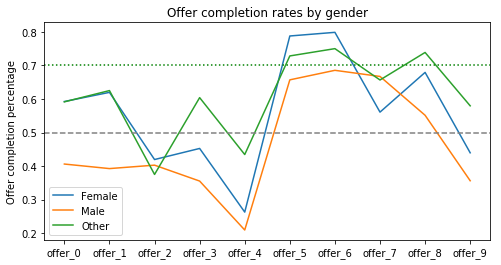

In [63]:
# plot completion rates across the genders
plt.figure(figsize=(8,4));
plt.plot(f_complete_pct, label='Female');
plt.plot(m_complete_pct, label='Male');
plt.plot(o_complete_pct, label='Other');
plt.axhline(y=0.5, color='gray', linestyle='--');
plt.axhline(y=0.7, color='green', linestyle='dotted');
plt.legend();
plt.ylabel('Offer completion percentage');
plt.title('Offer completion rates by gender');


The most successful offers across all genders are two discount offers 5 and 6. The other two discounts don't perform nearly as well. One of the main differences between the successful and not succesful discount offers are the channels in which they are promoted. Both low performing discounts don't promote through social. The other offer that performs poorly compared to the other offers also not promote through social is the information offer id 2.

One recommendation would be to promote all those offers through social as it apparently affects completion rates.


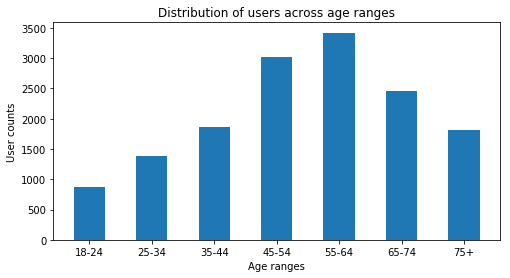

In [64]:
# plot distribution of users across age ranges
plt.figure(figsize=(8,4));
plt.hist(offer_df['age_range'], align='left', bins=range(8), rwidth=.5);
plt.xlabel('Age ranges');
plt.ylabel('User counts');
plt.title('Distribution of users across age ranges');

In [65]:
# Value counts per age range
offer_df.age_range.value_counts()

55-64    3421
45-54    3013
65-74    2457
35-44    1869
75+      1809
25-34    1380
18-24     876
Name: age_range, dtype: int64

In [66]:
# Create set of data for age ranges
df_18to24, offer_completions_18to24, total_received_18to24, complete_pct_18to24 = demographic_completion_info(column='age_range', kind='18-24')
df_25to34, offer_completions_25to34, total_received_25to34, complete_pct_25to34 = demographic_completion_info(column='age_range', kind='25-34')
df_35to44, offer_completions_35to44, total_received_35to44, complete_pct_35to44 = demographic_completion_info(column='age_range', kind='35-44')
df_45to54, offer_completions_45to54, total_received_45to54, complete_pct_45to54 = demographic_completion_info(column='age_range', kind='45-54')
df_55to64, offer_completions_55to64, total_received_55to64, complete_pct_55to64 = demographic_completion_info(column='age_range', kind='55-64')
df_65to74, offer_completions_65to74, total_received_65to74, complete_pct_65to74 = demographic_completion_info(column='age_range', kind='65-74')
df_75plus, offer_completions_75plus, total_received_75plus, complete_pct_75plus = demographic_completion_info(column='age_range', kind='75+')




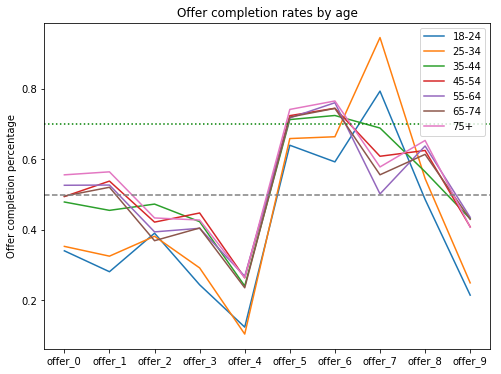

In [67]:
# plot the completion percentage across age ranges
plt.figure(figsize=(8,6));
plt.plot(complete_pct_18to24, label='18-24');
plt.plot(complete_pct_25to34, label='25-34');
plt.plot(complete_pct_35to44, label='35-44');
plt.plot(complete_pct_45to54, label='45-54');
plt.plot(complete_pct_55to64, label='55-64');
plt.plot(complete_pct_65to74, label='65-74');
plt.plot(complete_pct_75plus, label='75+');
plt.axhline(y=0.5, color='gray', linestyle='--');
plt.axhline(y=0.7, color='green', linestyle='dotted');
plt.legend();
plt.ylabel('Offer completion percentage');
plt.title('Offer completion rates by age');

It appears the same trend holds true when looking at the age ranges of the users. There are some new insights from this view of the completion rates. 

The informational offer 7 performs amazingly well in the 18-24 and 25-34 age range. While the other informational offer without the social channel performs the worst in that same age range.

In [68]:
# Take a look at the distribution of age range across income ranges
income_range_by_age = offer_df.groupby(['age_range', 'income_range'])['income_range'].count()
income_range_totals = offer_df.groupby('income_range')['income_range'].count()
age_income_dist = round(income_range_by_age/income_range_totals, 2)

In [69]:
age_income_dist

age_range  income_range
18-24      30k-49k         0.12
           49k-64k         0.07
           64k-80k         0.04
25-34      30k-49k         0.17
           49k-64k         0.12
           64k-80k         0.09
35-44      30k-49k         0.16
           49k-64k         0.16
           64k-80k         0.13
           80k-120k        0.06
45-54      30k-49k         0.17
           49k-64k         0.20
           64k-80k         0.21
           80k-120k        0.23
55-64      30k-49k         0.17
           49k-64k         0.20
           64k-80k         0.24
           80k-120k        0.32
65-74      30k-49k         0.13
           49k-64k         0.15
           64k-80k         0.17
           80k-120k        0.22
75+        30k-49k         0.08
           49k-64k         0.10
           64k-80k         0.13
           80k-120k        0.17
Name: income_range, dtype: float64

In [70]:
df_30to49, offer_completions_30to49, total_received_30to49, complete_pct_30to49 = demographic_completion_info(column='income_range', kind='30k-49k')
df_49to64, offer_completions_49to64, total_received_49to64, complete_pct_49to64 = demographic_completion_info(column='income_range', kind='49k-64k')
df_64to80, offer_completions_64to80, total_received_64to80, complete_pct_64to80 = demographic_completion_info(column='income_range', kind='64k-80k')
df_80to120, offer_completions_80to120, total_received_80to120, complete_pct_80to120 = demographic_completion_info(column='income_range', kind='80k-120k')

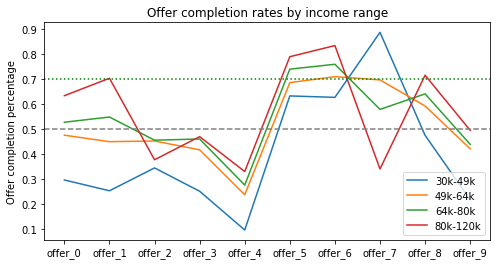

In [71]:
plt.figure(figsize=(8,4));
plt.plot(complete_pct_30to49, label='30k-49k');
plt.plot(complete_pct_49to64, label='49k-64k');
plt.plot(complete_pct_64to80, label='64k-80k');
plt.plot(complete_pct_80to120, label='80k-120k');
plt.axhline(y=0.5, color='gray', linestyle='--');
plt.axhline(y=0.7, color='green', linestyle='dotted');
plt.legend();
plt.ylabel('Offer completion percentage');
plt.title('Offer completion rates by income range');

### Breakdown of Female offer completion rates by demographic

In [82]:
female_df_clean = df_clean.query('gender == "F"')

In [84]:
fdf_30to49, foffer_completions_30to49, ftotal_received_30to49, fcomplete_pct_30to49 = demographic_completion_info(column='income_range', kind='30k-49k', df=female_df, df_clean=female_df_clean)
fdf_49to64, foffer_completions_49to64, ftotal_received_49to64, fcomplete_pct_49to64 = demographic_completion_info(column='income_range', kind='49k-64k', df=female_df, df_clean=female_df_clean)
fdf_64to80, foffer_completions_64to80, ftotal_received_64to80, fcomplete_pct_64to80 = demographic_completion_info(column='income_range', kind='64k-80k', df=female_df, df_clean=female_df_clean)
fdf_80to120, foffer_completions_80to120, ftotal_received_80to120, fcomplete_pct_80to120 = demographic_completion_info(column='income_range', kind='80k-120k', df=female_df, df_clean=female_df_clean)


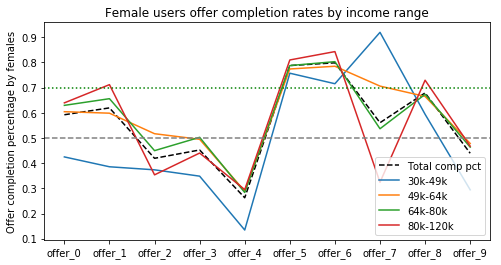

In [131]:
plt.figure(figsize=(8,4));
plt.plot(f_complete_pct, label='Total comp pct', color='k', linestyle='--');
plt.plot(fcomplete_pct_30to49, label='30k-49k');
plt.plot(fcomplete_pct_49to64, label='49k-64k');
plt.plot(fcomplete_pct_64to80, label='64k-80k');
plt.plot(fcomplete_pct_80to120, label='80k-120k');
plt.axhline(y=0.5, color='gray', linestyle='--');
plt.axhline(y=0.7, color='green', linestyle='dotted');
plt.legend();
plt.ylabel('Offer completion percentage by females');
plt.title('Female users offer completion rates by income range');

In [126]:
portfolio

,difficulty,duration,id,offer_type,reward,channel_web,channel_email,channel_mobile,channel_social,duration_hours,offer_id
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1,168,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1,120,2
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,1,0,96,3
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,1,0,168,4
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,1,0,0,240,5
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1,168,6
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1,240,7
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,1,1,1,72,8
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1,120,9
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,1,0,168,10


Taking a closer look at just Female completion rates across income ranges, we can see that the high earners complete more offers for offer 0, 1, 8, 9 than users with lower incomes. Lower income female users react strongest to offer 7 where high income earners have a very low completion percentage. Once again we can see that the lack of sending the offer through the social channel affects each user completion rate across the 4 offers: 2, 3, 4, and 9.

In [86]:
fdf_18to24, foffer_completions_18to24, ftotal_received_18to24, fcomplete_pct_18to24 = demographic_completion_info(column='age_range', kind='18-24', df=female_df, df_clean=female_df_clean)
fdf_25to34, foffer_completions_25to34, ftotal_received_25to34, fcomplete_pct_25to34 = demographic_completion_info(column='age_range', kind='25-34', df=female_df, df_clean=female_df_clean)
fdf_35to44, foffer_completions_35to44, ftotal_received_35to44, fcomplete_pct_35to44 = demographic_completion_info(column='age_range', kind='35-44', df=female_df, df_clean=female_df_clean)
fdf_45to54, foffer_completions_45to54, ftotal_received_45to54, fcomplete_pct_45to54 = demographic_completion_info(column='age_range', kind='45-54', df=female_df, df_clean=female_df_clean)
fdf_55to64, foffer_completions_55to64, ftotal_received_55to64, fcomplete_pct_55to64 = demographic_completion_info(column='age_range', kind='55-64', df=female_df, df_clean=female_df_clean)
fdf_65to74, foffer_completions_65to74, ftotal_received_65to74, fcomplete_pct_65to74 = demographic_completion_info(column='age_range', kind='65-74', df=female_df, df_clean=female_df_clean)
fdf_75plus, foffer_completions_75plus, ftotal_received_75plus, fcomplete_pct_75plus = demographic_completion_info(column='age_range', kind='75+', df=female_df, df_clean=female_df_clean)


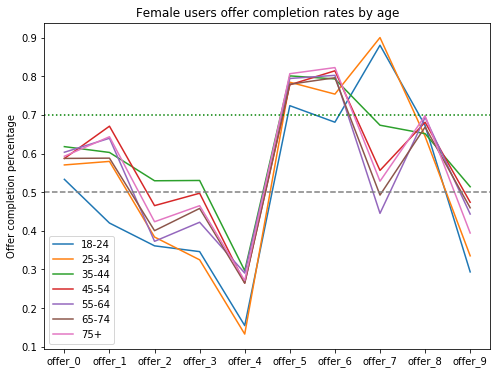

In [132]:
# plot the completion percentage across age ranges
plt.figure(figsize=(8,6));
plt.plot(fcomplete_pct_18to24, label='18-24');
plt.plot(fcomplete_pct_25to34, label='25-34');
plt.plot(fcomplete_pct_35to44, label='35-44');
plt.plot(fcomplete_pct_45to54, label='45-54');
plt.plot(fcomplete_pct_55to64, label='55-64');
plt.plot(fcomplete_pct_65to74, label='65-74');
plt.plot(fcomplete_pct_75plus, label='75+');
plt.axhline(y=0.5, color='gray', linestyle='--');
plt.axhline(y=0.7, color='green', linestyle='dotted');
plt.legend();
plt.ylabel('Offer completion percentage');
plt.title('Female users offer completion rates by age');

Lookin at the female data across age ranges does tell a slightly different story about completion rate performance. As we saw in the previous chart offer 2, 3 and 9 were some of the lower performing offers with each having a less than 50% completion rate across the income ranges except for the 49-64k income range for offer 2. 

What we see here is that the 35-44 age group is the only one that exceeds the 50% completion rate for offers 2, 3 and 9. If our goal was to send offers to the demographics who will have over a 50% completion rate for offers then we would target sending the worst performing offers to just that demographic ff women in the age range of 35-44.

### Breakdown of male offer completion rates by demographic


In [91]:
male_df_clean = df_clean.query('gender == "M"')

In [92]:
mdf_30to49, moffer_completions_30to49, mtotal_received_30to49, mcomplete_pct_30to49 = demographic_completion_info(column='income_range', kind='30k-49k', df=male_df, df_clean=male_df_clean)
mdf_49to64, moffer_completions_49to64, mtotal_received_49to64, mcomplete_pct_49to64 = demographic_completion_info(column='income_range', kind='49k-64k', df=male_df, df_clean=male_df_clean)
mdf_64to80, moffer_completions_64to80, mtotal_received_64to80, mcomplete_pct_64to80 = demographic_completion_info(column='income_range', kind='64k-80k', df=male_df, df_clean=male_df_clean)
mdf_80to120, moffer_completions_80to120, mtotal_received_80to120, mcomplete_pct_80to120 = demographic_completion_info(column='income_range', kind='80k-120k', df=male_df, df_clean=male_df_clean)


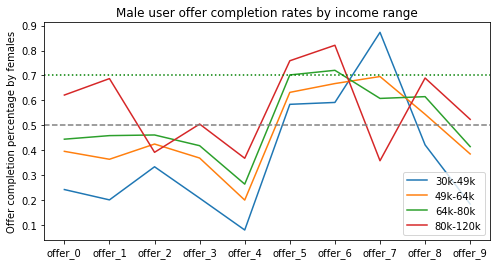

In [128]:
plt.figure(figsize=(8,4));
plt.plot(mcomplete_pct_30to49, label='30k-49k');
plt.plot(mcomplete_pct_49to64, label='49k-64k');
plt.plot(mcomplete_pct_64to80, label='64k-80k');
plt.plot(mcomplete_pct_80to120, label='80k-120k');
plt.axhline(y=0.5, color='gray', linestyle='--');
plt.axhline(y=0.7, color='green', linestyle='dotted');
plt.legend();
plt.ylabel('Offer completion percentage by females');
plt.title('Male user offer completion rates by income range');

Male users in the high income range (80-120k) have the highest completion rates across almost all of the offers except for offer 7. Offer 7 also had the lowest performance amongst female users in that same income range. I would avoid sending offer 7 to either male or female groups as it had the lowest completion percentage across both groups. 

Low income (30k-49k) male users only have high completion rates for offers 5-7 and I would restrict sending any of the other offers to that age range.

In [95]:
mdf_18to24, moffer_completions_18to24, mtotal_received_18to24, mcomplete_pct_18to24 = demographic_completion_info(column='age_range', kind='18-24', df=male_df, df_clean=male_df_clean)
mdf_25to34, moffer_completions_25to34, mtotal_received_25to34, mcomplete_pct_25to34 = demographic_completion_info(column='age_range', kind='25-34', df=male_df, df_clean=male_df_clean)
mdf_35to44, moffer_completions_35to44, mtotal_received_35to44, mcomplete_pct_35to44 = demographic_completion_info(column='age_range', kind='35-44', df=male_df, df_clean=male_df_clean)
mdf_45to54, moffer_completions_45to54, mtotal_received_45to54, mcomplete_pct_45to54 = demographic_completion_info(column='age_range', kind='45-54', df=male_df, df_clean=male_df_clean)
mdf_55to64, moffer_completions_55to64, mtotal_received_55to64, mcomplete_pct_55to64 = demographic_completion_info(column='age_range', kind='55-64', df=male_df, df_clean=male_df_clean)
mdf_65to74, moffer_completions_65to74, mtotal_received_65to74, mcomplete_pct_65to74 = demographic_completion_info(column='age_range', kind='65-74', df=male_df, df_clean=male_df_clean)
mdf_75plus, moffer_completions_75plus, mtotal_received_75plus, mcomplete_pct_75plus = demographic_completion_info(column='age_range', kind='75+', df=male_df, df_clean=male_df_clean)


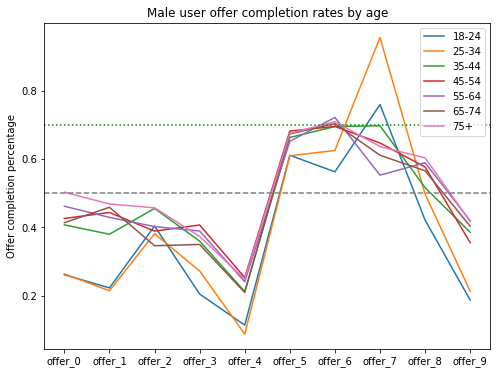

In [127]:
# plot the completion percentage across age ranges
plt.figure(figsize=(8,6));
plt.plot(mcomplete_pct_18to24, label='18-24');
plt.plot(mcomplete_pct_25to34, label='25-34');
plt.plot(mcomplete_pct_35to44, label='35-44');
plt.plot(mcomplete_pct_45to54, label='45-54');
plt.plot(mcomplete_pct_55to64, label='55-64');
plt.plot(mcomplete_pct_65to74, label='65-74');
plt.plot(mcomplete_pct_75plus, label='75+');
plt.axhline(y=0.5, color='gray', linestyle='--');
plt.axhline(y=0.7, color='green', linestyle='dotted');
plt.legend();
plt.ylabel('Offer completion percentage');
plt.title('Male user offer completion rates by age');

As we can see in the above chart none of the age ranges have over a 50% completion for any offer except for offers 5-8. Depending on the information we know about the users we should send offers to all age ranges except for offer 7 if they are in the high income range (80k-120k).

# Conclusion

All of the offers that were not promoted through social performed much worse than offers that were promoted through the social channel. Starbucks should consider promoting every offer through social to see if it improves the completion rates for offers 2-4 and offer 9 which had the lowest completion rates throughout each demographic. 

Information offer 7 had the highest offer completion % out of any offer within the age ranges of 25-34 as well as the 30k-49k income range. But I would recommend not sending offer 7 to the high income range 80-120k as they have low offer completion rates

I would recommend continuing to send bogo offers 0, 1, 8 to users in the highest income range of 80k-120 as the completion rates are very high in the 65-70% range. 

Discount offers 5 and 6 are the strongest offers across all demographics regardless of gender, age or income. My recommendation would be to continue to send these offers to every demographic. 